# Visualize Parameter Space with Exhaustive Optimizer

ITK optimizers are commonly used to select suitable values for various parameters, such as choosing how to transform a moving image to register with a fixed image. A variety of image metrics and transform classes are available to guide the optimization process, each of which may employ parameters unique to its own implementation. It is often useful to visualize how changes in parameters will impact the metric value and the optimization process.

The `ExhaustiveOptimizer` class exists to evaluate a metric over a windowed parameter space of fixed step size. This example shows how to use `ExhaustiveOptimizerv4` with the `MeanSquaresImageToImageMetricv4` metric and `Euler2DTransform` transform to survey performance over a parameter space and visualize the results with `matplotlib`.

In [1]:
import os
import sys
import itertools
from math import pi, sin, cos, sqrt
from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import numpy as np

import itk
from itkwidgets import view, compare, checkerboard, cm

module_path = os.path.abspath(os.path.join('.'))

if module_path not in sys.path:
    sys.path.append(module_path)

### Get sample data to register

In this example we seek to transform an image of an orange to overlay on the image of an apple. We will eventually use the `MeanSquaresImageToImageMetricv4` class to inform the optimizer about how the two images are related given the current parameter state. We can visualize the fixed and moving images with `ITKWidgets`.

In [2]:
fixed_img_path = 'apple.jpg'
moving_img_path = 'orange.jpg'

In [3]:
if not os.path.exists(fixed_img_path):
    url = 'https://data.kitware.com/api/v1/file/5cad1aec8d777f072b181870/download'
    urlretrieve(url, fixed_img_path)
if not os.path.exists(moving_img_path):
    url = 'https://data.kitware.com/api/v1/file/5cad1aed8d777f072b181879/download'
    urlretrieve(url, moving_img_path)

In [4]:
fixed_img = itk.imread(fixed_img_path, itk.F)
moving_img = itk.imread(moving_img_path, itk.F)

In [5]:
compare(fixed_img, moving_img, ui_collapsed=True)

AppLayout(children=(HBox(children=(Label(value='Link:'), Checkbox(value=False, description='cmap'), Checkbox(v…

### Define and Initialize the Transform

In this example we will use an `Euler2DTransform` instance to represent how the moving image will be sampled from the fixed image. The [Euler2DTransform](https://itk.org/Doxygen/html/classitk_1_1Euler2DTransform.html) documentation shows that the transform has three parameters, first a rotation around a fixed center, followed by a 2D translation. We use a `CenteredTransformInitializer` to estimate what may be a "good" fixed center point at which to define the transform prior to conducting optimization.

In [6]:
dimension = 2
FixedImageType = itk.Image[itk.F, dimension]
MovingImageType = itk.Image[itk.F, dimension]
TransformType = itk.Euler2DTransform[itk.D]
OptimizerType = itk.ExhaustiveOptimizerv4[itk.D]
MetricType = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType]
TransformInitializerType = \
    itk.CenteredTransformInitializer[itk.MatrixOffsetTransformBase[itk.D,2,2],
                                     FixedImageType, MovingImageType]
RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType,MovingImageType]

In [7]:
transform = TransformType.New()

initializer = TransformInitializerType.New(
    Transform=transform,
    FixedImage=fixed_img,
    MovingImage=moving_img,
)
initializer.InitializeTransform()

### Run Optimization

We rely on the `ExhaustiveOptimizerv4` class to visualize the parameter space. For this example we choose to visualize the metric value over the first two parameters only, so we set the number of steps in the third dimension to zero. The angle and translation parameters are measured on different scales, so we set the optimizer to take steps of reasonable size along each dimension. An observer is used to save the results of each step.

In [8]:
metric_results = dict()

metric = MetricType.New()
optimizer = OptimizerType.New()

optimizer.SetNumberOfSteps([10,10,0])
    
scales = optimizer.GetScales()
scales.SetSize(3)
scales.SetElement(0, 0.1)
scales.SetElement(1, 1.0)
scales.SetElement(2, 1.0)
optimizer.SetScales(scales)

def collect_metric_results():
    metric_results[tuple(optimizer.GetCurrentPosition())] = \
            optimizer.GetCurrentValue()

optimizer.AddObserver(itk.IterationEvent(), collect_metric_results)

registration = RegistrationType.New(Metric=metric,
    Optimizer=optimizer,
    FixedImage=fixed_img,
    MovingImage=moving_img,
    InitialTransform=transform,
    NumberOfLevels=1)

In [9]:
registration.Update()

print(f'MinimumMetricValue: {optimizer.GetMinimumMetricValue():.4f}\t'
      f'MaximumMetricValue: {optimizer.GetMaximumMetricValue():.4f}\n'
      f'MinimumMetricValuePosition: {list(optimizer.GetMinimumMetricValuePosition())}\t'
      f'MaximumMetricValuePosition: {list(optimizer.GetMaximumMetricValuePosition())}\n'
      f'StopConditionDescription: {optimizer.GetStopConditionDescription()}\t')

MinimumMetricValue: 8195.5765	MaximumMetricValue: 13799.5822
MinimumMetricValuePosition: [0.0, 0.0, 0.0]	MaximumMetricValuePosition: [0.6000000000000001, 10.0, 0.0]
StopConditionDescription: ExhaustiveOptimizerv4: Completed sampling of parametric space of size 3	


### Visualize Parameter Space as 2D Scatter Plot

We can use `matplotlib` to view the results of each discrete optimizer step as a 2D scatter plot. In this case the horizontal axis represents the angle that the image is rotated about its fixed center in radians and the vertical axis represents the horizontal distance that the image is translated after rotation. The value of `MeanSquaresImageToImageMetricv4` for each transformation is represented via color gradients. We can also directly plot optimizer extrema for visualization.

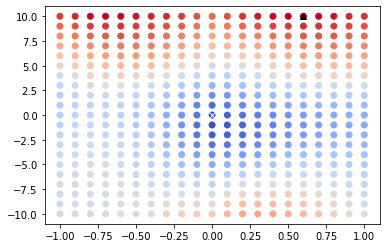

In [10]:
fig = plt.figure()
ax = plt.axes()
ax.scatter([x[0] for x in metric_results.keys()],
             [x[1] for x in metric_results.keys()],
             c=list(metric_results.values()),
             cmap='coolwarm');
ax.plot(optimizer.GetMinimumMetricValuePosition().GetElement(0),
           optimizer.GetMinimumMetricValuePosition().GetElement(1),
           'wx')
ax.plot(optimizer.GetMaximumMetricValuePosition().GetElement(0),
           optimizer.GetMaximumMetricValuePosition().GetElement(1),
           'k^')

### Visualize Parameter Space as 3D Surface

We can also plot results in 3D space with `numpy` and `matplotlib`. In this example we use `np.meshgrid` to define the parameter domain and define corresponding metric results as an accompanying `numpy` array. The resulting graph can be used to visualize gradients and visually identify extrema.

In [11]:
x_unique = list(set(x for (x,y,_) in metric_results.keys()))
y_unique = list(set(y for (x,y,_) in metric_results.keys()))
x_unique.sort()
y_unique.sort()

In [12]:
X, Y = np.meshgrid(x_unique, y_unique)
Z = np.array([[metric_results[(x,y,0)] for x in x_unique] for y in y_unique])

In [13]:
np.shape(Z)

(21, 21)

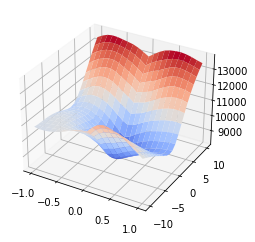

In [14]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X,Y,Z,cmap='coolwarm')

### Clean up

In [15]:
os.remove(fixed_img_path)
os.remove(moving_img_path)